In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import librosa
import librosa.display
from IPython.display import Audio

In [2]:
# Define path to datasets
DATA_REDUCED = "./MESD_Speaker_embedded_naturalness-reduced_female_voices"
DATA_NATURAL = "./MESD_All"

## GET SAMPLE

In [3]:
SAMPLE_FILE = '/Anger_C_A_abajo.wav'

# load the audio file to get the sample
samples, sample_rate = librosa.load(DATA_NATURAL + SAMPLE_FILE, sr = None)

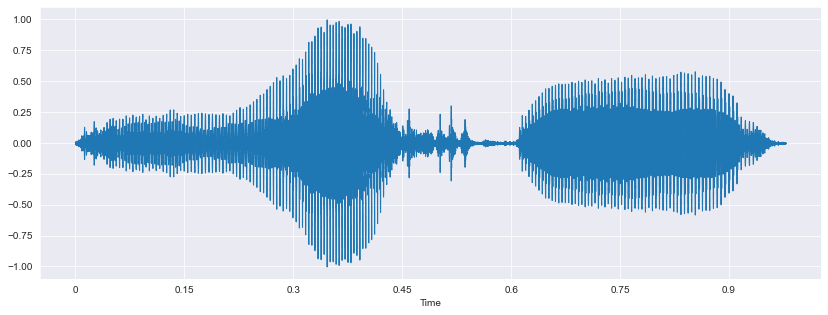

In [4]:
# visualize the sound wave
plt.figure(figsize = (14, 5))
librosa.display.waveshow(samples, sr = sample_rate)

In [6]:
# play the audio directly
Audio(DATA_NATURAL + SAMPLE_FILE)

In [7]:
print ('Sample shape ', samples.shape, 'Sample rate ', sample_rate, 'Data type', type(samples))

Sample shape  (46924,) Sample rate  48000 Data type <class 'numpy.ndarray'>


/Users/helloimrosie/opt/anaconda3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  return f(*args, **kwargs)


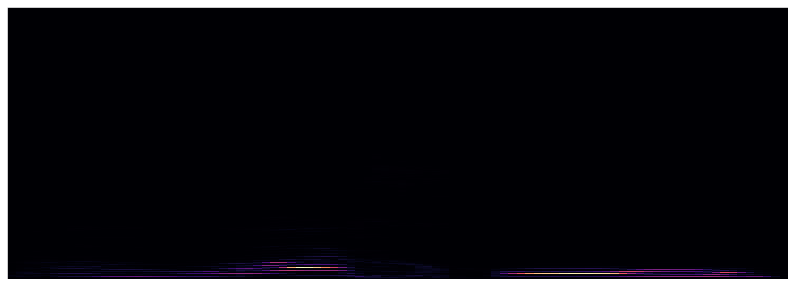

In [8]:
# Spectrograms: plot frequency vs time to indicate the Amplitude of each frequency
plt.figure(figsize = (14, 5))
sgram = librosa.stft(samples)
librosa.display.specshow(sgram)

/var/folders/xq/79ls2g8547bdfhql62t94dt00000gn/T/ipykernel_58725/2150084059.py:9: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(format='+% dB')


<Figure size 1008x360 with 0 Axes>

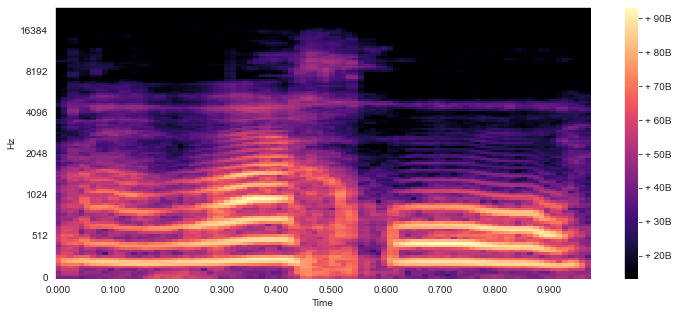

In [9]:
# Modify the to use Mel Scale (a scale of pitches, s.t. each unit is judged by listeners to be equal in pitches distance from the next) instead of Frequency
plt.figure(figsize = (14, 5))
sgram_mag, _ = librosa.magphase(sgram)
mel_scale_sgram = librosa.feature.melspectrogram(S = sgram_mag, sr = sample_rate)
# use the decibel scale to get the final Mel Spectrogram
plt.figure(figsize = (12, 5))
mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)
librosa.display.specshow(mel_sgram, sr=sample_rate, x_axis='time', y_axis='mel')
plt.colorbar(format='+% dB')

## OVERALL EXPLORATION

In [11]:
entries = os.listdir(DATA_NATURAL)

In [67]:
dataset = []
for entry in entries:
    entryArr = entry.split("_")
    if len(entryArr) != 4:
        continue
    dataset.append([])
    dataset[-1].append(entry)
    dataset[-1].append(entryArr[0]) # emotion
    dataset[-1].append(entryArr[1]) # gender
    dataset[-1].append(entryArr[3].split(".")[0]) # word

In [68]:
df = pd.DataFrame(dataset, columns=['filename', 'emotion', 'gender', 'word'])

In [52]:
df.head(5)

,filename,emotion,gender,word
0,Anger_C_B_danino.wav,Anger,C,danino
1,Sadness_F_B_explosion.wav,Sadness,F,explosion
2,Disgust_C_B_robo.wav,Disgust,C,robo
3,Neutral_M_B_bola.wav,Neutral,M,bola
4,Happiness_F_B_baile.wav,Happiness,F,baile


In [53]:
num_data = len(df)
num_emotion = len(df['emotion'].unique())
num_gender = len(df['gender'].unique())
num_words = len(df['word'].unique())
print(f'There are total of {num_data} audio pieces.')
print(f'Number of emotions: {num_emotion}')
print(f'Number of genders: {num_gender}')
print(f'Number of words: {num_words}')

There are total of 807 audio pieces.
Number of emotions: 6
Number of genders: 3
Number of words: 201


In [54]:
# gender exploration
df['gender'].value_counts()

F    270
M    270
C    267
Name: gender, dtype: int64

In [55]:
# emotion exploration
df['emotion'].value_counts()

Sadness      135
Disgust      135
Fear         135
Anger        134
Neutral      134
Happiness    134
Name: emotion, dtype: int64

In [71]:
df['audio_len'] = 0
df['sample_rate'] = 0

for i in range(len(df)):
  entry = df.iloc[i,0]
  file_path = DATA_NATURAL +'/'+ entry
  sample, sample_rate = librosa.load(file_path, sr = None)
  df.iloc[i, -2] = len(sample)
  df.iloc[i, -1] = sample_rate

In [77]:
df.head()

,filename,emotion,gender,word,audio_len,sample_rate
0,Anger_C_B_danino.wav,Anger,C,danino,36650,48000
1,Sadness_F_B_explosion.wav,Sadness,F,explosion,38775,48000
2,Disgust_C_B_robo.wav,Disgust,C,robo,31764,48000
3,Neutral_M_B_bola.wav,Neutral,M,bola,17098,48000
4,Happiness_F_B_baile.wav,Happiness,F,baile,25375,48000


In [81]:
min_length = df['audio_len'].min()
max_length = df['audio_len'].max()
print(f'Minimum length of data: {min_length}')
print(f'Maximum length of data: {max_length}')

Minimum length of data: 9554
Maximum length of data: 111922


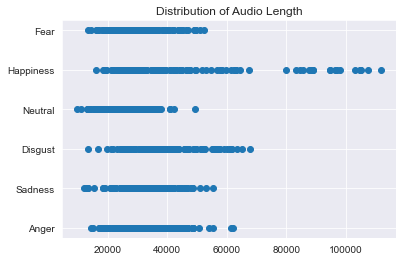

In [78]:
# Audio Length
plt.plot(df['audio_len'], df['emotion'], 'o')
plt.title("Distribution of Audio Length")
plt.show()

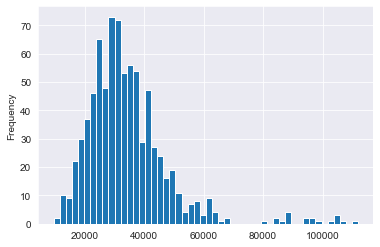

In [79]:
df['audio_len'].plot.hist(bins = 50) #(bins=12, alpha=0.5)
plt.show()

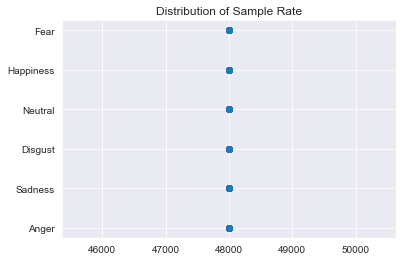

In [80]:
# Sample Rate
plt.plot(df['sample_rate'], df['emotion'], 'o')
plt.title("Distribution of Sample Rate")
plt.show()

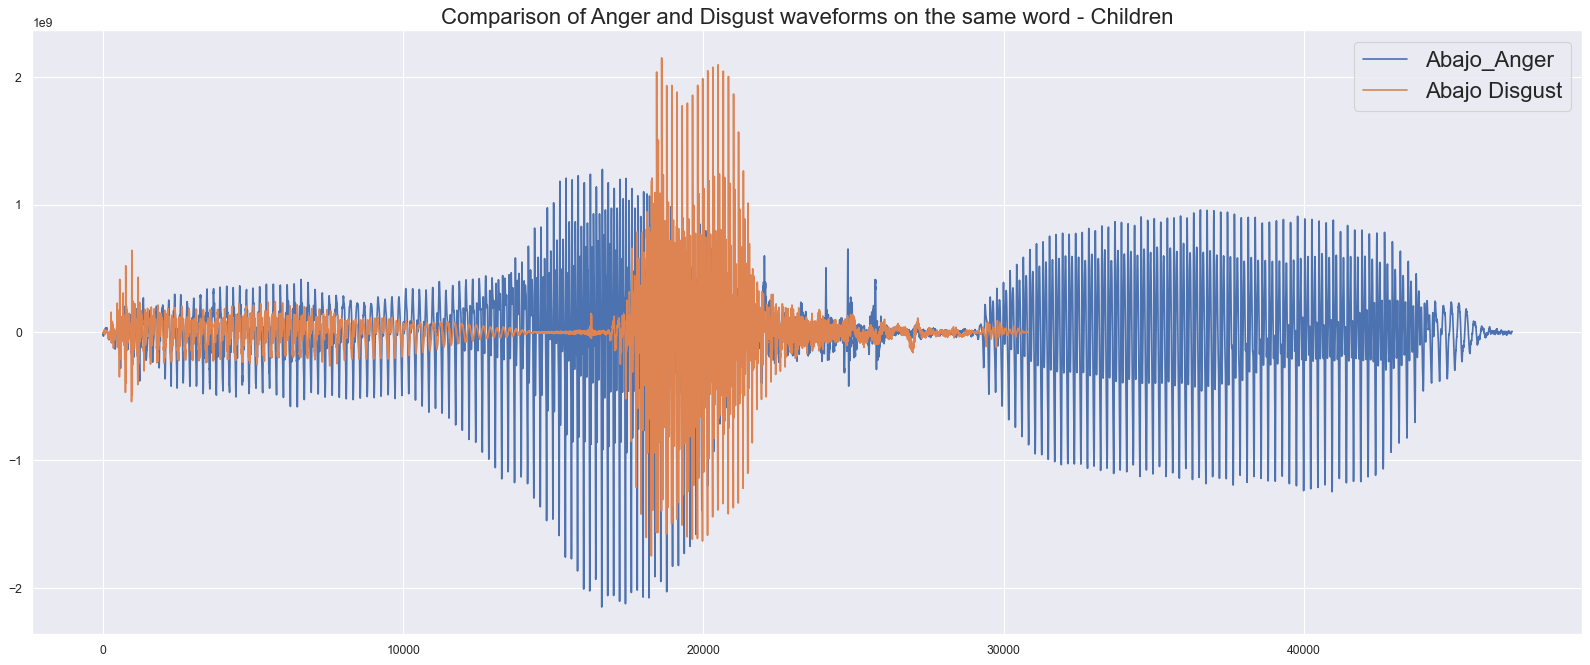

In [82]:
from scipy.io import wavfile

sns.set()
sample_rate_anger, data_anger = wavfile.read(DATA_NATURAL + "/Anger_C_A_abajo.wav")
sample_rate_disgust, data_disgust = wavfile.read(DATA_NATURAL + "/Disgust_C_A_abajo.wav")

plt.figure(figsize=(25, 10), dpi=80)
plt.plot(data_anger, label = "Abajo_Anger")
plt.plot(data_disgust, label = "Abajo Disgust")

plt.title("Comparison of Anger and Disgust waveforms on the same word - Children", fontsize = 20)
plt.legend(fontsize = 20)
plt.show()

## Baseline (Naive) Model for Inference

As we want to have a baseline model accuracy for future comparison, we shall try training several models such as Logistic Regression, Random Forest, and XGBoost as our initial tries.

In [85]:
from time import time
from tqdm import tqdm

start = time()
waves = {}
for entry in entries:
    if entry == "desktop.ini":
        continue
    waves[entry] = wavfile.read(DATA_NATURAL + "/" + entry)[1]
end = time()

print(f'Total time consumed: {round(end - start)} sec.')

Total time consumed: 1 sec.


In [86]:
print("First 5 files and values we got:")
for file_path in list(waves.keys())[:5]:
    print(file_path, ":", waves[file_path])

First 5 files and values we got:
Anger_C_B_danino.wav : [-25143808 -23139072 -22129152 ... -11658496 -11516160 -12822016]
Sadness_F_B_explosion.wav : [-36851456 -36726784 -28044032 ...   9056768   5738496   3642624]
Disgust_C_B_robo.wav : [ -4726784  -6704640  -8269056 ... -40250112 -41356544 -41054720]
Neutral_M_B_bola.wav : [46875904 47985920 49126144 ... -1845760 -1715456 -1337600]
Happiness_F_B_baile.wav : [-18235648 -18588416 -17968896 ... -13232384 -12732672 -13949696]


Considering what we should feed to our models, we think of having moments of several orders on our waveforms. And in order to have multiple choices, we could use order from $2$ ($\mathbb{E}[X^2]$) to order $5$ ($\mathbb{E}[X^5]$)

In [111]:
from scipy.stats import moment

def compute_moment(wave, m = 1):
    return moment(wave, m)

anger_moment_2 = compute_moment(data_anger/10**8, 2)
print(f'Example of inputting Anger sample we got previously: {anger_moment_2}')

Example of inputting Anger sample we got previously: 15.07101795574352


In [121]:
df_naive = df.copy() # we want to have a copy of df for naive model training
DIVISION = 10**8
for m in tqdm(range(2, 6)):
    df_naive[f'moment_{m}'] = 0
    for i in range(len(df_naive)):
        wav = waves[df_naive.iloc[i, 0]]/DIVISION
        df_naive.iloc[i, -1] = compute_moment(wav, m)

100%|██████████| 4/4 [00:00<00:00,  5.62it/s]


In [122]:
df_naive.head(5)

,filename,emotion,gender,word,audio_len,sample_rate,moment_2,moment_3,moment_4,moment_5
0,Anger_C_B_danino.wav,Anger,C,danino,36650,48000,17.765192,-28.412990,1438.861616,-8476.561228
1,Sadness_F_B_explosion.wav,Sadness,F,explosion,38775,48000,14.614481,-30.187705,1264.536986,-6158.135253
2,Disgust_C_B_robo.wav,Disgust,C,robo,31764,48000,23.696864,-95.304497,3647.994376,-30107.807315
3,Neutral_M_B_bola.wav,Neutral,M,bola,17098,48000,16.175127,22.307221,2134.971707,10465.392226
4,Happiness_F_B_baile.wav,Happiness,F,baile,25375,48000,25.317067,-42.178195,2444.949916,-11637.730828


In [123]:
# Encode emotion categories as integer
df_naive['emotion_ordinal'] = df_naive['emotion'].astype('category').cat.codes
df_naive.head(5)

,filename,emotion,gender,word,audio_len,sample_rate,moment_2,moment_3,moment_4,moment_5,emotion_ordinal
0,Anger_C_B_danino.wav,Anger,C,danino,36650,48000,17.765192,-28.412990,1438.861616,-8476.561228,0
1,Sadness_F_B_explosion.wav,Sadness,F,explosion,38775,48000,14.614481,-30.187705,1264.536986,-6158.135253,5
2,Disgust_C_B_robo.wav,Disgust,C,robo,31764,48000,23.696864,-95.304497,3647.994376,-30107.807315,1
3,Neutral_M_B_bola.wav,Neutral,M,bola,17098,48000,16.175127,22.307221,2134.971707,10465.392226,4
4,Happiness_F_B_baile.wav,Happiness,F,baile,25375,48000,25.317067,-42.178195,2444.949916,-11637.730828,3


### Naive Model Training Part

Step1 : Split the data into Train and Test

In [125]:
from sklearn.model_selection import train_test_split

moments = [f'moment_{i}' for i in range(2, 6)]
X_train, X_test, y_train, y_test = train_test_split(df_naive[moments], df_naive['emotion_ordinal'], test_size=0.2, random_state=4800)

#### Model1: Logistic Regression

In [126]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(multi_class='multinomial', max_iter=3000)
lr.fit(X_train, y_train)
lr_score = lr.score(X_test, y_test)

#### Model2: Random Forest

In [127]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier().fit(X_train, y_train)
rf_score = rf.score(X_test, y_test)

#### Model3: XGBoost

In [134]:
import xgboost

xgb = xgboost.XGBClassifier().fit(X_train, y_train)
xgb_score = xgb.score(X_test, y_test)

/Users/helloimrosie/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/helloimrosie/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/helloimrosie/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isi

[10:47:29] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_44tbtwf8c1/croots/recipe/xgboost-split_1659548960882/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [135]:
print("------------ Accuracy under Models ------------")
print(f'Logistic Regression Accuracy: {lr_score}')
print(f'Random Forest Accuracy: {rf_score}')
print(f'XGBoost Accuracy: {xgb_score}')

------------ Accuracy under Models ------------
Logistic Regression Accuracy: 0.22839506172839505
Random Forest Accuracy: 0.2962962962962963
XGBoost Accuracy: 0.25925925925925924


## Transformers Approach